`f_` is the intended order to go through the notebooks if I forgot what I did in the future.

In [1]:
import sys
from pathlib import Path
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
from E9_fn import util

import util_thm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

c:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\.venv\Lib\site-packages\gftool\precision.py:16: UserWarning: No quad precision datatypes available!
Some functions might be less accurate.
  warnings.warn("No quad precision datatypes available!\n"


In [2]:
bool_plot = True   # set to false if gathering invert data

# Inverting the $\beta, S$ conjugate pair
Having nonzero interaction doesn't change how we do this, as is the case for matching.

## Reading data (jump here to change params)
Let's first start with the full $N - S_{tot}$ space scan for a fixed set of model parameters. The folder names are a bit different from NI, otherwise things are the same.

In [30]:
tnpspc = {  # tenpy specs used to generate folder names
    "geometry": "sawtooth",
    "spin": "spinless",      # "spinful", "spinless"
    "interacting": "I",
    "L": 25,
    "chi": 64,
}
model_params = {
    "V": -0.1,
    "shift": -2,
    "tp": 1.41421356237,
}
n_s_tar = 0.5

In [31]:
# folder_name = f"{tnpspc['geometry']}_{tnpspc['spin']}_{tnpspc['interacting']}_L{tnpspc['L']}_chi{tnpspc['chi']}"
folder_name = f"ST_SL_I_L25_t1_tpsqrt2_shf{model_params['shift']}_V{model_params['V']}_chi64"
csv_name = f"V{model_params['V']}_tp{model_params['tp']}_shift{model_params['shift']}_ns{n_s_tar}.csv"
csv_path = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\matching_results",
                folder_name, csv_name)
df_match = pd.read_csv(csv_path)

# df_match

In [32]:
L_subregion = tnpspc['L']
N_s = n_s_tar * 2 * L_subregion
beta_vals = df_match["beta"].to_numpy(dtype=float)
mask_beta = np.isclose(beta_vals, 20)
s2_tot_max_beta = df_match[mask_beta]["S2_tot"].to_numpy(dtype=float)
Ntot_max_beta = df_match[mask_beta]["Ntot"].to_numpy(dtype=float)

## The tamed flat-ish band
We no longer expect the band to be exactly flat (as shown in the broadening of the high Renyi entropy feature around $\mu = V/2$).

In [33]:
N_range = np.arange(N_s + 0. * L_subregion, N_s + 2 * L_subregion)
S_range = np.linspace(0., 40.0, 201) * (L_subregion / 25)

See `f1` for notes on interpolation.

In [34]:
N_N_pts = len(N_range)
N_S_pts = len(S_range)
n_r_range = (N_range - N_s) / (2 * L_subregion)

### Plots
A few things to notice: (looking at $V = 1$)
* I only get solutions at where $n_r$ is much closer to $n_s$ than before.
* The amount of cooling I get is in general much less, and I don't always get cooling for $n_r > n_s$: $n_s = 0.5$ seems like a special case
* I need much smaller $S_{tot}$ to see cooling.
* $V_{offset} are almost horizontal lines.

In [35]:
beta_all,   [mu_glob_all, V_offset_all, s2_s_all, s2_r_all, sigma2_s_all, sigma2_r_all
    ] = util_thm.invert_NS_mat_df(df_match, N_range, S_range,
            ["mu_glob", "V_offset", "s2_s", "s2_r", "sigma2_s", "sigma2_r"])
varsigma_all = (sigma2_s_all - sigma2_r_all) / (sigma2_s_all + sigma2_r_all)

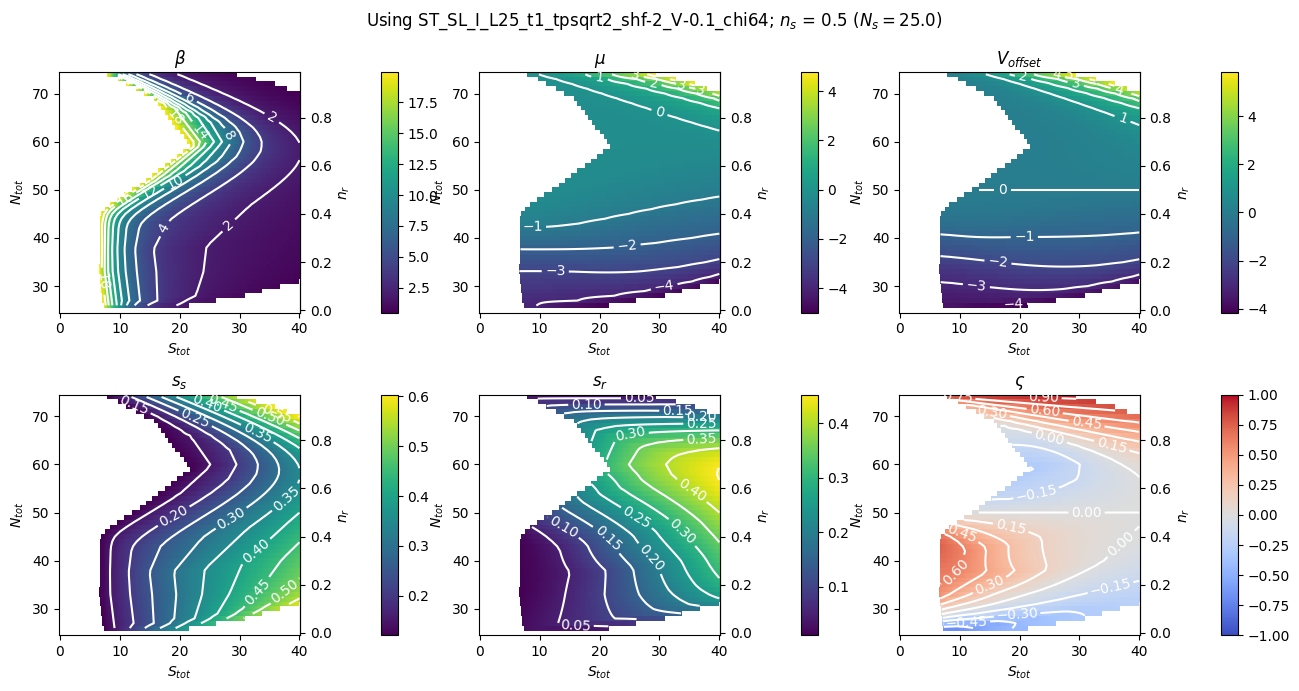

In [36]:
if bool_plot:
    fig_fixS, axs_fixS_all = plt.subplots(2, 3 * 2, figsize = (13, 7), gridspec_kw = {"width_ratios": [15, 1] * 3})
    axs_fixS = axs_fixS_all[:, ::2]
    axs_fixS_cb = axs_fixS_all[:,1::2]

    for ax, ax_cb, params_mat, cmap, str_label, clim in zip(
            axs_fixS.flatten(),
            axs_fixS_cb.flatten(),
            [beta_all, mu_glob_all, V_offset_all, s2_s_all, s2_r_all, varsigma_all],
            ["viridis", "viridis", "viridis", "viridis", "viridis", "coolwarm"],
            [r"$\beta$", r"$\mu$", r"$V_{offset}$", r"$s_s$", r"$s_r$", r"$\varsigma$"],
            [None, None, None, None, None, (-1, 1)]):
        img = ax.pcolormesh(S_range, N_range, params_mat, clim = clim, cmap = cmap)
        ax.set_box_aspect(1)
        ax.set_title(str_label)
        ax.set_xlabel(r"$S_{tot}$")
        ax.set_ylabel(r"$N_{tot}$")
        ryax = ax.secondary_yaxis('right', functions = (lambda x: (x - N_s) / (2 * L_subregion), lambda x: x * 2 * L_subregion + N_s))
        ryax.set_ylabel(r"$n_r$")
        cntr = ax.contour(S_range, N_range, params_mat, colors = "white", linestyles = "solid", levels = 10)
        ax.clabel(cntr, inline = True)
        fig_fixS.colorbar(img, cax = ax_cb, fraction = 0.5, location = 'right')

        # Plot some limitations set by either physical argument or EoS available
        # ax.plot(s2_tot_max_beta, Ntot_max_beta, color = "blue", ls = "--")  # EoS available
    fig_fixS.suptitle(rf"Using {folder_name}; $n_s$ = {n_s_tar} ($N_s =${N_s})")
    fig_fixS.tight_layout(w_pad = 0.1)

Still don't know what to do with these constant $V_{offset}$ plots.

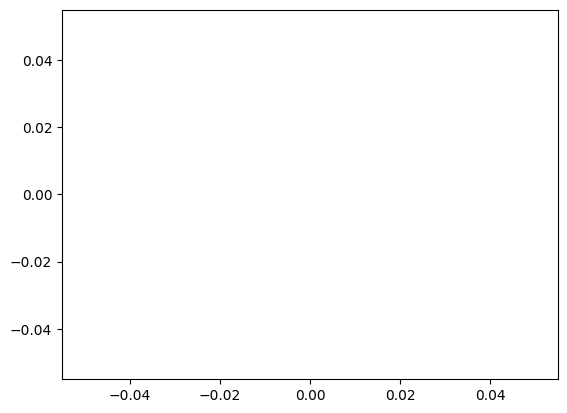

In [37]:
if bool_plot:
    N_curve, s_s_curve = util.parametric_slice_2D(N_range, S_range, V_offset_all, sigma2_s_all, 0.25,
                                                  single_valued = "axis0")
    plt.plot(N_curve, s_s_curve)

## Save to .csv

I will create a new file for each $n_s$. The subdirectory within `invert_S_results` is the same as that in `matching_results`.

In [38]:
raise(Exception("stop here"))

Exception: stop here

### Building the invert S results Dataframe

In [ ]:
records_invert_S = []
for i_S, Stot in enumerate(S_range):
    for i_Ntot, Ntot in enumerate(N_range):
        records_invert_S.append({
            "Stot": np.round(Stot, decimals = 10),
            "Ntot": Ntot,
            "n_s": n_s_tar,
            "beta": beta_all[i_Ntot, i_S],
            "mu_glob": mu_glob_all[i_Ntot, i_S],
            "V_offset": V_offset_all[i_Ntot, i_S],
            "s2_s": s2_s_all[i_Ntot, i_S],
            "s2_r": s2_r_all[i_Ntot, i_S],
            "sigma2_s": sigma2_s_all[i_Ntot, i_S],
            "sigma2_r": sigma2_r_all[i_Ntot, i_S],
            "varsigma": varsigma_all[i_Ntot, i_S],
        })
df_invert_S_rslt = pd.DataFrame.from_records(records_invert_S)

In [ ]:
invert_S_results_folder = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\invert_S_results",
                folder_name)
invert_S_results_folder.mkdir(exist_ok = True)
csv_path = Path(invert_S_results_folder, csv_name)

df_invert_S_rslt.to_csv(csv_path, index = False)